# Q1

In [72]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch
from torchvision.ops import nms

In [4]:
def imshow(image, title = "Image", size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

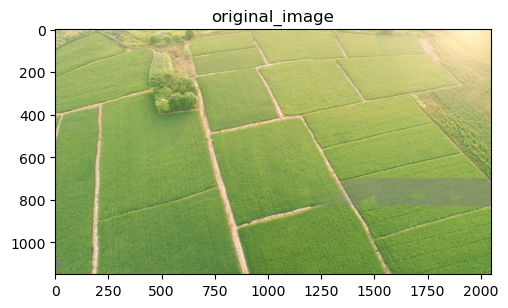

In [5]:
img = cv2.imread("AerialView.jpeg")

imshow(img,"original_image" )

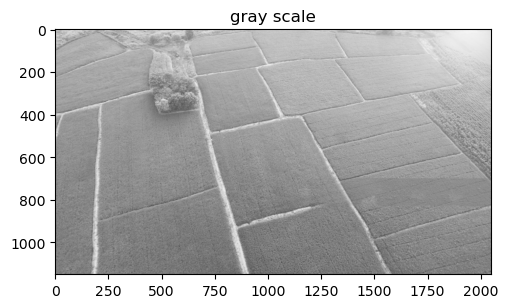

In [103]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(img_gray, "gray scale")



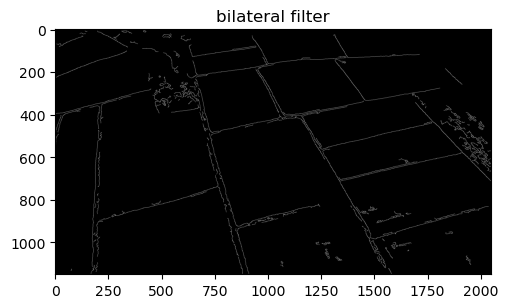

In [104]:
bilateral_filter = cv2.bilateralFilter(img_gray, 9, 75, 95)
low_th = 0
high_th = 80
bilat_fil_img = cv2.Canny(bilateral_filter, low_th, high_th)
imshow(bilat_fil_img, "bilateral filter")

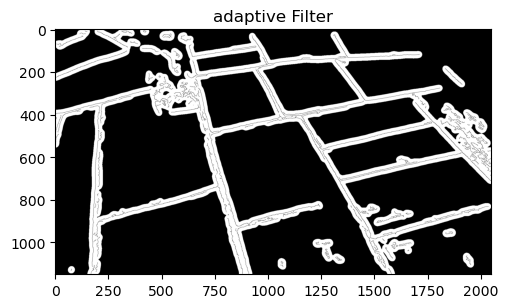

In [105]:
adaptive_img = cv2.adaptiveThreshold(bilat_fil_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,41,1)
adaptive_img = 255 - adaptive_img


imshow(adaptive_img, "adaptive Filter")

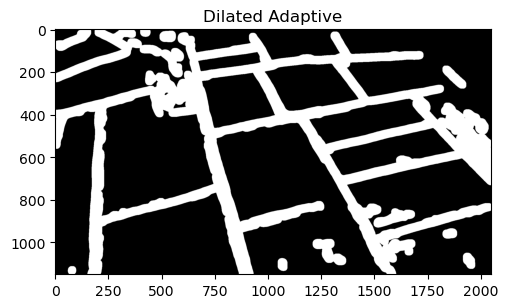

In [107]:
kernel = np.ones((2,2),np.uint8)
delited_adptive = cv2.dilate(adaptive_img, kernel, iterations = 6)
imshow(delited_adptive ,"Dilated Adaptive")

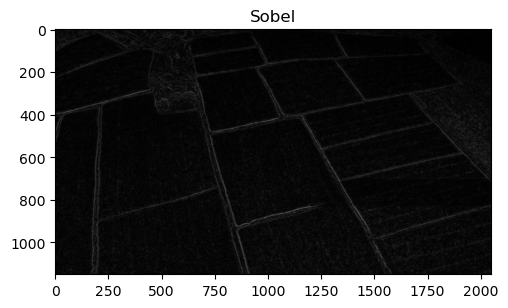

In [109]:
medianF_applied = cv2.medianBlur(img_gray.copy(), 11)
gausianF_applied = cv2.GaussianBlur(img_gray.copy(), (11, 11), 0)
bilateralF_applied = cv2.bilateralFilter(img_gray.copy(), 11, 75, 75)

scale = 1
delta = 0
ddepth = cv2.CV_16S
    
grad_x = cv2.Sobel(gausianF_applied.copy(), ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
grad_y = cv2.Sobel(gausianF_applied.copy(), ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)

abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)

sobel_img = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

imshow(sobel_img, "Sobel")

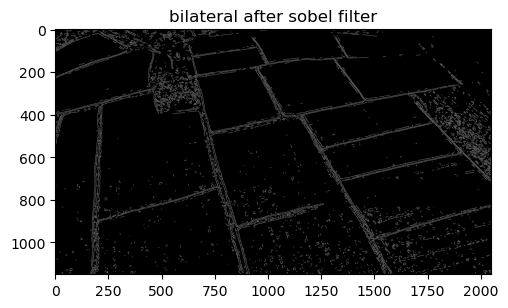

In [112]:
bilateral_filter = cv2.bilateralFilter(sobel_img, 7, 70, 95)
low_th = 25
high_th =30
bilat_after_sobel = cv2.Canny(bilateral_filter, low_th, high_th)
imshow(bilat_after_sobel, "bilateral after sobel filter")

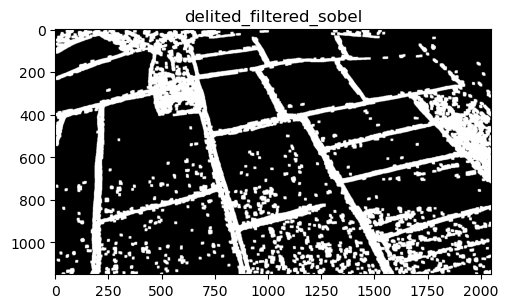

In [113]:
delited_sobel = cv2.dilate(bilat_after_sobel, kernel, iterations = 10)
imshow(delited_sobel ,"delited_filtered_sobel")

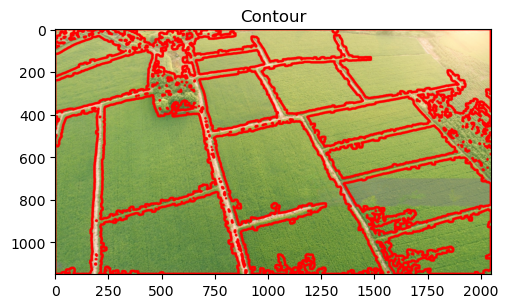

In [114]:
img_backup = img.copy()
def drawContours(image):
  contours, hierarchy = cv2.findContours(image = cv2.bitwise_not(image), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
  # for cnt in contours:
  img_contour = cv2.drawContours(img_backup, contours, -1, (0, 0, 255), 10, cv2.LINE_AA)
  imshow(img_contour, "Contour")
  return contours

contours = drawContours(delited_sobel)

0 => m00: 333541.5, cx: 1109, cy: 816
1 => m00: 283541.0, cx: 1540, cy: 133
2 => m00: 219917.0, cx: 450, cy: 598
3 => m00: 186082.0, cx: 546, cy: 994
4 => m00: 140283.0, cx: 1725, cy: 766
5 => m00: 131167.0, cx: 95, cy: 770
6 => m00: 93276.5, cx: 1856, cy: 1017
7 => m00: 91797.5, cx: 845, cy: 291
8 => m00: 76331.5, cx: 1199, cy: 269
9 => m00: 75384.0, cx: 228, cy: 248
10 => m00: 75180.5, cx: 1575, cy: 576
11 => m00: 70194.0, cx: 1464, cy: 429
12 => m00: 29230.5, cx: 137, cy: 117
13 => m00: 17378.0, cx: 558, cy: 148


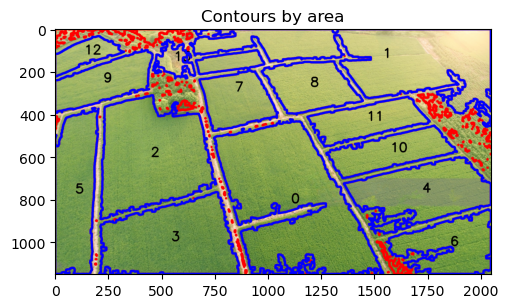

In [115]:
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
for (i,c) in enumerate(sorted_contours):
    M = cv2.moments(c)
    if M['m00'] > 8500:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        print(f"{i} => m00: {M['m00']}, cx: {cx}, cy: {cy}")
        cv2.putText(img_backup, str(i), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 5)
        cv2.drawContours(img_backup, [c], -1, (255,0,0), 10)
imshow(img_backup, 'Contours by area')

# Q2

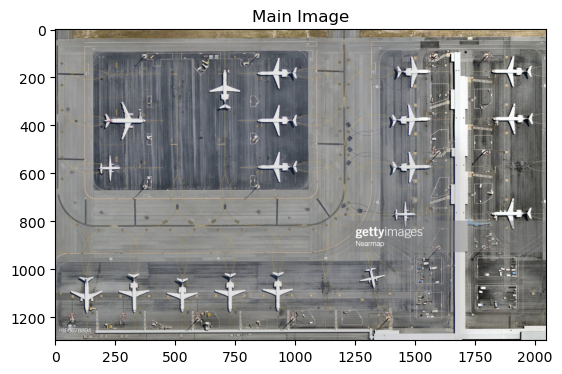

In [43]:
img2 = cv2.imread("airport.jpg")
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
imshow(img2, "Main Image")

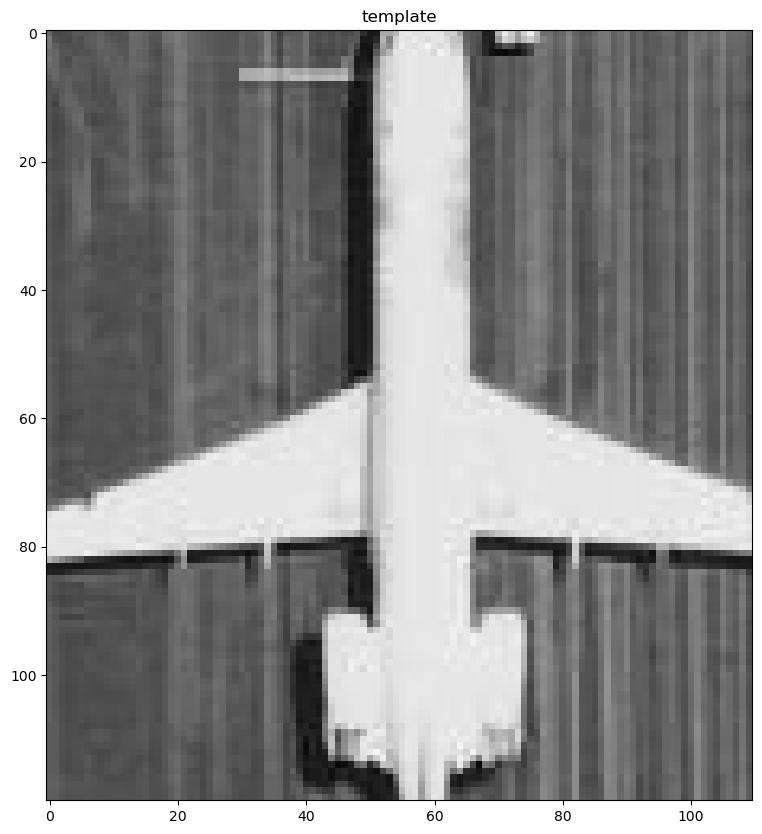

In [44]:
template = img2_gray[180: 300, 650: 760]
imshow(template, "template")

In [45]:
w, h = template.shape[::-1]

In [46]:
methods = ["cv2.TM_CCOEFF", "cv2.TM_CCOEFF_NORMED", "cv2.TM_CCORR", "cv2.TM_SQDIFF", "cv2.TM_SQDIFF_NORMED"]

In [47]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

In [120]:
img3 = img2_gray.copy()
img2 = cv2.imread("airport.jpg")

boxes = []
scores = []

angles = [i*5.625 for i in range(64)]
scales = [1 * i for i in [1.1, 0.9, 0.8, 0.7, 0.60,]]

for angle in angles:

    for scale in scales:

        width = int(template.shape[1] * scale)
        height = int(template.shape[0] * scale)
        dim = (width, height)

        # resize image
        tmp_temp = cv2.resize(template, dim, interpolation = cv2.INTER_AREA)

        tmp_temp =rotate_image(tmp_temp, angle=angle)

        method = eval(methods[1])

        blur = cv2.blur(img3, (3, 3))

        res = cv2.matchTemplate(blur, tmp_temp, method)
        threshold = 0.641
        loc = np.where(res >= threshold)
        sim = res[res >= threshold]

        # sim = [i for i in sim[] if i != -1]

        for i, pt in enumerate(zip(*loc[::-1])):
            boxes.append((pt[0], pt[1], (pt[0] + w), (pt[1] + h)))
            scores.append([sim[i]])
            # print("test")
            # if i == 2:
            #     break
    #     break
    # break
cv2.imwrite("detected.jpg", img2)
boxes = torch.tensor(boxes, dtype=torch.float32)
scores = torch.tensor(scores, dtype=torch.float32)
scores = torch.flatten(scores)
chosen_boxes = nms(boxes = boxes, scores = scores, iou_threshold=0.2)

for bound in chosen_boxes:
    x1 = (boxes[bound])[0]
    y1 = (boxes[bound])[1]
    x2 = (boxes[bound])[2]
    y2 = (boxes[bound])[3]
    cv2.rectangle(img2, (int(x1.numpy()), int(y1.numpy())), (int(x2.numpy()), int(y2.numpy())), (0, 0, 255), 2)
int(x1.numpy()), int(y1.numpy())

(87, 1065)

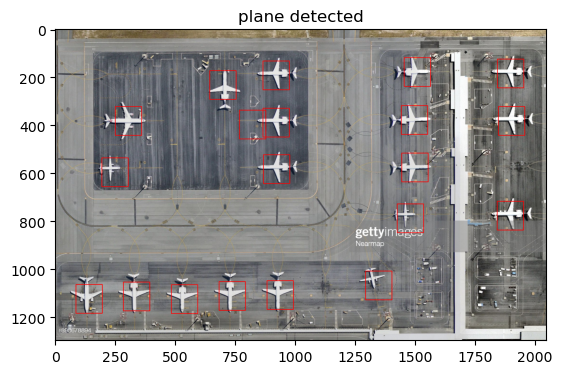

In [121]:
imshow(img2, "plane detected")

# Q3

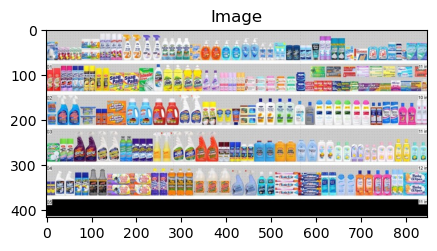

In [123]:
img_q3 = cv2.imread("q3.jpg")
img_q3_gray = cv2.cvtColor(img_q3, cv2.COLOR_BGR2GRAY)
imshow(img_q3)

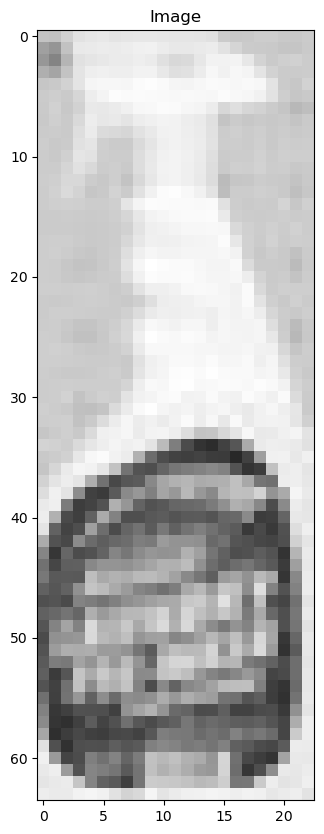

In [57]:
template1 = img_q3_gray[146: 210, 297: 320]
imshow(template1)

In [58]:
w, h = template.shape[::-1]

found 0th object
found 1th object


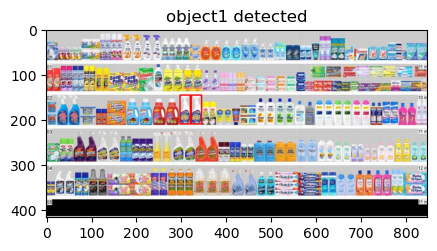

2 objects/object where found


In [63]:
img4 = img_q3_gray.copy()
img_q3 = cv2.imread("q3.jpg")

method = eval(methods[1])

blur = cv2.blur(img3, (3, 3))

res = cv2.matchTemplate(img4, template1, method)
threshold = 0.95
loc = np.where(res >= threshold)

for i,pt in enumerate(zip(*loc[::-1])):
  print(f"found {i}th object")
  cv2.rectangle(img_q3, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)

cv2.imwrite("detected_q3.jpg", img_q3)

imshow(img_q3, "object1 detected")

print(f"{i+1} objects/object where found")

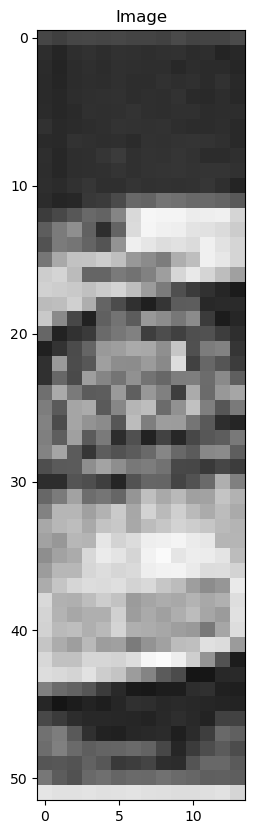

In [93]:
template2 = img_q3_gray[243:295, 192:206]
imshow(template2)

In [94]:
w, h = template.shape[::-1]

found 0th object
found 1th object
found 2th object


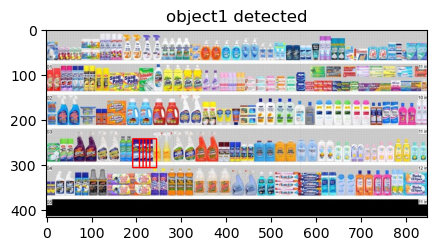

3 objects/object where found


In [99]:
img4 = img_q3_gray.copy()
img_q3 = cv2.imread("q3.jpg")

method = eval(methods[1])

blur = cv2.blur(img3, (3, 3))

res = cv2.matchTemplate(img4, template2, method)
threshold = 0.97
loc = np.where(res >= threshold)

for i,pt in enumerate(zip(*loc[::-1])):
  print(f"found {i}th object")
  cv2.rectangle(img_q3, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)

cv2.imwrite("detected_q3.jpg", img_q3)

imshow(img_q3, "object1 detected")

print(f"{i+1} objects/object where found")